## Step1: Data Exploration
**Objective**:
To explore and analyze the Playing Cards dataset in order to understand its structure and characteristics before the modeling phase.

**Main Goals**:
- Perform an initial assessment of data quality and completeness.
- Identify attribute types and their distributions.
- Detect missing, inconsistent, or anomalous values.
- Visualize data through appropriate plots to support interpretation.

**Methods and Tools**:
- Statistical summaries using descriptive measures (mean, median, standard deviation, etc.).
- Visual exploration with histograms, boxplots, and scatter plots.
- Correlation analysis between features.

**Outcome**:
- Clear overview of the dataset and its key properties.
- Identification of relevant features and potential preprocessing needs.
- Foundation for subsequent steps in the Intelligent System design process, following the KDD methodology (selection, preprocessing, modeling, and evaluation).


### 0) Setup and Utility Functions
In order to work with the dataset, we define some utility functions to handle YOLO format annotations and load dataset splits and class names from a possible `data.yaml` file.

In [ ]:
# Root Path of the dataset
# DATA_ROOT = "./datasets/Playing-Cards-Object-Detection-Dataset"
DATA_ROOT = "./datasets/Playing-Cards-Images-Object-Detection-Dataset"

# Dependencies
import os, json, math, yaml, random, statistics
from pathlib import Path
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from pathlib import Path
import re

# Utility functions
def yolo_to_xyxy(xc, yc, w, h, W, H):
    """Converts a YOLO normalized bounding box (xc,yc,w,h in [0,1]) to pixel (x1,y1,x2,y2)."""
    x1 = (xc - w/2) * W
    y1 = (yc - h/2) * H
    x2 = (xc + w/2) * W
    y2 = (yc + h/2) * H
    return max(0, x1), max(0, y1), min(W-1, x2), min(H-1, y2)

def load_classes_from_yaml(root):
    """Loads class names from a YOLO data.yaml."""
    candidates = list(Path(root).rglob("data.yaml"))
    if candidates:
        with open(candidates[0], "r") as f:
            data = yaml.safe_load(f)
        names = data.get("names")
        if isinstance(names, dict):
            # the format usually is {0:'A',1:'B',...}
            max_k = max(int(k) for k in names.keys())
            arr = [names.get(i, names.get(str(i), f'class_{i}')) for i in range(max_k+1)]
            return arr
        if isinstance(names, list):
            return names
    # fallback: None
    return None

def find_splits(root):
    """Finds dataset splits (train/val/test) in the given root directory."""
    root = Path(root)
    splits = {}
    for split in ["train","valid","val","test"]:
        img_dir = root / split / "images"
        lbl_dir = root / split / "labels"
        if img_dir.exists() and lbl_dir.exists():
            splits[split] = {"images": img_dir, "labels": lbl_dir}
    # if no splits found, check for a single 'images' and 'labels' folder
    if not splits:
        img_dir = root / "images"
        lbl_dir = root / "labels"
        if img_dir.exists() and lbl_dir.exists():
            splits["all"] = {"images": img_dir, "labels": lbl_dir}
    return splits

def read_label_file(path):
    """Reads a YOLO label file and returns a list of bounding boxes."""
    out = []
    with open(path, "r") as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != 5 and len(parts) != 6: # len==6 for possible confidence score
                continue
            cls = int(float(parts[0]))
            xc, yc, w, h = map(float, parts[1:5])
            out.append((cls, xc, yc, w, h))
    return out


def load_dataset(DATA_ROOT):
    dataset_type = detect_dataset_type(DATA_ROOT)
    print(f"Detected dataset type: {dataset_type.upper()}\n")

    splits = {}
    classes = None

    if dataset_type == 'yolo':
        # --- YOLO DATASET ---
        for split_name in ['train', 'valid', 'test']:
            img_dir = Path(DATA_ROOT) / split_name / "images"
            lbl_dir = Path(DATA_ROOT) / split_name / "labels"

            splits[split_name] = {
                'images': sorted(glob(str(img_dir / "*"))),
                'labels': sorted(glob(str(lbl_dir / "*.txt")))
            }

        yaml_path = os.path.join(DATA_ROOT, 'data.yaml')
        if os.path.exists(yaml_path):
            with open(yaml_path) as f:
                data = yaml.safe_load(f)
                classes = data.get('names', None)

    elif dataset_type == 'csv_voc':
        # --- CSV / VOC (XML) DATASET ---
        # note: each split folder contains both images and xml files in the same directory
        for split_name in ['train', 'test']:
            split_dir = Path(DATA_ROOT) / split_name / split_name
            img_paths = sorted(glob(str(split_dir / "*.png"))) + sorted(glob(str(split_dir / "*.jpg")))
            xml_paths = sorted(glob(str(split_dir / "*.xml")))

            splits[split_name] = {
                'images': img_paths,
                'labels': xml_paths
            }

        # Optional: read class names from CSV if available
        train_csv = os.path.join(DATA_ROOT, 'train_labels.csv')
        if os.path.exists(train_csv):
            df = pd.read_csv(train_csv)
            if 'class' in df.columns:
                classes = sorted(df['class'].unique())

    else:
        raise ValueError("Unsupported dataset structure — cannot detect YOLO or CSV/VOC layout.")

    return splits, classes

def convert_voc_df_to_yolo_df(labels_df):
    """
    Convert Pascal VOC-style DataFrame to YOLO-style normalized format.
    Input DataFrame must have columns:
    ['image_path', 'class', 'xmin', 'ymin', 'xmax', 'ymax', 'width', 'height']
    """
    df = labels_df.copy()

    df['x_center'] = ((df['xmin'] + df['xmax']) / 2) / df['width']
    df['y_center'] = ((df['ymin'] + df['ymax']) / 2) / df['height']
    df['width_norm'] = (df['xmax'] - df['xmin']) / df['width']
    df['height_norm'] = (df['ymax'] - df['ymin']) / df['height']

    yolo_df = df[['image_path', 'class', 'x_center', 'y_center', 'width_norm', 'height_norm']]
    return yolo_df

def parse_voc_annotations(xml_files):
    records = []

    for xml_file in xml_files:
        tree = ET.parse(xml_file)
        root = tree.getroot()

        # --- Basic file info ---
        filename = root.findtext('filename')
        folder = root.findtext('folder')
        image_path = root.findtext('path') or str(Path(xml_file).with_suffix('.png'))

        # --- Image size ---
        size = root.find('size')
        width = int(size.findtext('width')) if size is not None else None
        height = int(size.findtext('height')) if size is not None else None
        depth = int(size.findtext('depth')) if size is not None else None

        # --- One record per object (bounding box) ---
        for obj in root.findall('object'):
            class_name = obj.findtext('name')
            bbox = obj.find('bndbox')
            xmin = int(bbox.findtext('xmin'))
            ymin = int(bbox.findtext('ymin'))
            xmax = int(bbox.findtext('xmax'))
            ymax = int(bbox.findtext('ymax'))

            records.append({
                'image_path': image_path,
                'filename': filename,
                'folder': folder,
                'class': class_name,
                'xmin': xmin,
                'ymin': ymin,
                'xmax': xmax,
                'ymax': ymax,
                'width': width,
                'height': height,
                'depth': depth
            })

    return pd.DataFrame(records)

def load_and_prepare_labels(DATA_ROOT, splits, classes):
    dataset_type = detect_dataset_type(DATA_ROOT)
    print(f"Preparing labels for dataset type: {dataset_type.upper()}")

    # 1️YOLO dataset → already YOLO-like
    if dataset_type == 'yolo':
        # You already build labels_df somewhere else, so just return it
        print("YOLO dataset detected — no conversion needed.")
        return None  # or your existing YOLO labels_df logic

    # 2️XML dataset → parse and convert
    elif dataset_type == 'csv_voc':
        xml_files = splits['train']['labels'] + splits['test']['labels']
        labels_df = parse_voc_annotations(xml_files)
        print(f"Parsed {len(labels_df)} bounding boxes from XML files.")

        # Normalize to YOLO codes
        labels_df['class'] = labels_df['class'].apply(normalize_card_name)
        invalid = labels_df['class'].isna().sum()
        if invalid > 0:
            print(f"Warning: {invalid} labels could not be normalized to known YOLO classes.")

        yolo_df = convert_voc_df_to_yolo_df(labels_df)

        # Map to class IDs using the canonical YOLO class list
        name_to_id = {name: i for i, name in enumerate(YOLO_CLASSES)}
        yolo_df['class_id'] = yolo_df['class'].map(name_to_id)

        return yolo_df


    else:
        raise ValueError("Unknown dataset type. Cannot prepare labels.")



### 1) Dataset Structure and Classes
We first check if the dataset is organized in the following structure:
```
images/
    train/
      images/
      labels/
    valid/
      images/
      labels/
    test/
      images/
      labels/
data.yaml
```

Than we check for the presence of `data.yaml` file to load class names. Since we are analysing a playing cards dataset, we expect to find 52 classes (one for each card).

In [28]:
splits, classes = load_dataset(DATA_ROOT)

print("=" * 60)
print("DATASET SPLITS AND CLASSES SUMMARY")
print("=" * 60)
for s, d in splits.items():
    print(f"- {s}: \n\timages={d['images']},\n\tlabels={d['labels']}")

print("-" * 60)
if classes is not None:
    print(f"\nClasses found in data.yaml: {len(classes)} classes")
    for i, name in enumerate(classes):
        if i > 5: 
            print("  ...")
            break
        print(f"  {i}: {name}")
else:
    print("\nNo data.yaml file found, classes will be shown as numeric IDs.")

Detected dataset type: CSV_VOC

DATASET SPLITS AND CLASSES SUMMARY
- train: 
	images=['datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/22.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/3.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/33.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/45.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/51.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/56.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/57.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/64.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/65.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/69.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/72.png', 'datasets/Playing-Cards-Images-Object-Detection-Dataset/train/train/

### 2) Check how the dataset is splitted
We identify the splits (train, valid, test) and count the number of images and labels in each split to get an overview of the dataset distribution made by the author.

We also check for missing labels (images without corresponding label files).

In [34]:
rows = []
for split, d in splits.items():
    img_paths = d['images']
    lbl_paths = {Path(p).stem: p for p in d['labels']}

    for ip in img_paths:
        stem = Path(ip).stem
        lp = lbl_paths.get(stem, None)
        rows.append({
            "split": split,
            "image_path": ip,
            "label_path": lp
        })

df = pd.DataFrame(rows)

# creates summary statistics for every split
print("=" * 60)
print("DATASET DISTRIBUTION OVERVIEW")
print("=" * 60)

split_stats = []
for split in splits.keys():
    split_df = df[df['split'] == split]
    num_images = len(split_df)
    num_labels = split_df['label_path'].notna().sum()
    missing_labels = split_df['label_path'].isna().sum()
    coverage = (num_labels / num_images * 100) if num_images > 0 else 0
    
    split_stats.append({
        'Split': split,
        'Images': num_images,
        'Labels': num_labels,
        'Missing': missing_labels,
        'Coverage': f"{coverage:.2f}%"
    })

# Final table
stats_df = pd.DataFrame(split_stats)
print("\n" + stats_df.to_string(index=False))

# Global statistics
total_images = df.shape[0]
total_labels = df['label_path'].notna().sum()
total_missing = df['label_path'].isna().sum()
missing_pct = (total_missing / total_images * 100) if total_images > 0 else 0

print("\n" + "-" * 60)
print("GLOBAL STATISTICS")
print("-" * 60)
print(f"Total images:          {total_images:,}")
print(f"Total labels:          {total_labels:,}")
print(f"Missing labels:        {total_missing:,}")
print(f"Missing percentage:    {missing_pct:.2f}%")
print(f"Dataset completeness:  {100 - missing_pct:.2f}%")
print("=" * 60)

DATASET DISTRIBUTION OVERVIEW

Split  Images  Labels  Missing Coverage
train     525     524        1   99.81%
 test      96      96        0  100.00%

------------------------------------------------------------
GLOBAL STATISTICS
------------------------------------------------------------
Total images:          621
Total labels:          620
Missing labels:        1
Missing percentage:    0.16%
Dataset completeness:  99.84%


### 3) Images Dimensions and Aspect Ratios
We analyze the dimensions (width, height) of the images in each split and compute their aspect ratios (width/height). This helps us understand the variability in image sizes and shapes. 

We then plot histograms of widths, heights, and aspect ratios for each split.

             width       height      aspect
count   621.000000   621.000000  621.000000
mean    389.803543   485.925926    0.814151
std     369.722673   421.066037    0.260434
min     112.000000   150.000000    0.520900
25%     183.000000   259.000000    0.665455
50%     198.000000   275.000000    0.716981
75%     500.000000   550.000000    0.820769
max    3917.000000  2809.000000    2.000000


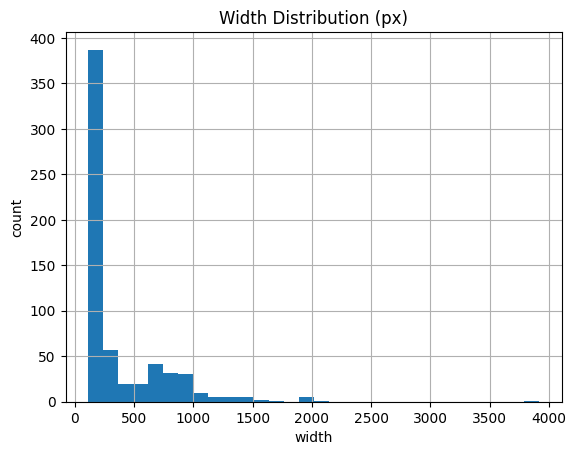

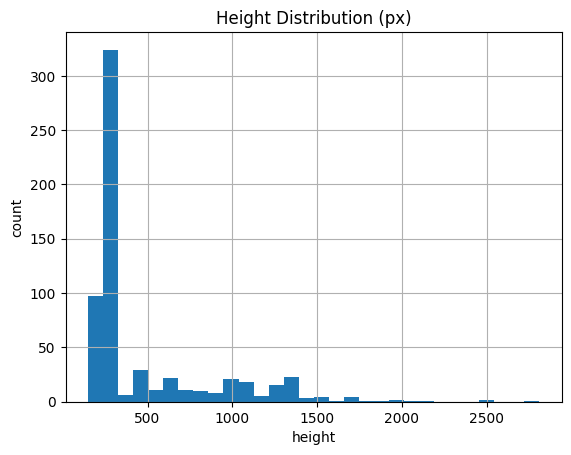

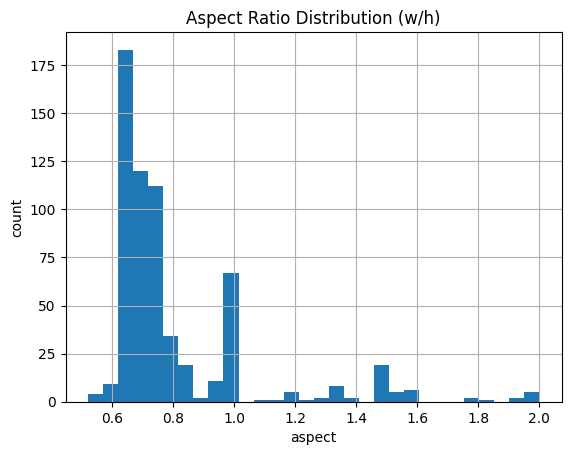

['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']


In [ ]:
def get_img_size(p):
    try:
        with Image.open(p) as im:
            return im.width, im.height
    except Exception:
        return None, None

# Create a dataframe containing image sizes and aspect ratios
# and than use the describe() method to get summary statistics
sizes = df['image_path'].apply(get_img_size)
df['width'] = [w for w,h in sizes]
df['height'] = [h for w,h in sizes]
df['aspect'] = df['width'] / df['height']

print(df[['split','width','height','aspect']].describe())

# Histograms
plt.figure()
df['width'].dropna().hist(bins=30)
plt.title('Width Distribution (px)')
plt.xlabel('width')
plt.ylabel('count')
plt.show()

plt.figure()
df['height'].dropna().hist(bins=30)
plt.title('Height Distribution (px)')
plt.xlabel('height')
plt.ylabel('count')
plt.show()

plt.figure()
df['aspect'].dropna().hist(bins=30)
plt.title('Aspect Ratio Distribution (w/h)')
plt.xlabel('aspect')
plt.ylabel('count')
plt.show()

### 4) YOLO Bounding Boxes Analysis and Classes Distribution
We parse the YOLO format annotation files to extract bounding box information (class, x_center, y_center, width, height) for each image. We convert the normalized coordinates to absolute pixel values based on the image dimensions using the utility function defined earlier.
Then, we analyze the distribution of bounding box sizes (width, height, area) and aspect ratios (width/height) across the dataset. We also check for anomalies such as bounding boxes with zero area or coordinates outside the image boundaries.

For class distribution, we count the number of bounding boxes per class, then we show some statistics like max, min, mean instances per class, and plot the frequency of the top 30 classes.

In [ ]:
label_rows = []
bad_norm = 0
zero_area = 0

for idx, r in df.dropna(subset=['label_path']).iterrows():
    # --- Try to get image size (only if missing in df) ---
    if 'width' in r and 'height' in r:
        W, H = int(r['width'] or 0), int(r['height'] or 0)
    else:
        try:
            with Image.open(r['image_path']) as im:
                W, H = im.size
        except Exception:
            W, H = 0, 0

    # --- Try reading YOLO-format label file ---
    try:
        items = read_label_file(r['label_path'])
    except Exception:
        items = []

    for (cls, xc, yc, w, h) in items:
        # check anomalies
        if not (0 <= xc <= 1 and 0 <= yc <= 1 and 0 <= w <= 1 and 0 <= h <= 1):
            bad_norm += 1
        if w <= 0 or h <= 0:
            zero_area += 1

        # compute derived metrics
        area = w * h
        aspect = (w / h) if h > 0 else None

        label_rows.append({
            "split": r['split'],
            "image_path": r['image_path'],
            "class_id": cls,
            "xc": xc, "yc": yc, "w": w, "h": h,
            "area": area, "aspect": aspect,
            "img_w": W, "img_h": H
        })

print("=" * 60)
print("BOUNDING BOXES ANALYSIS")
print("=" * 60)
labels_df = load_and_prepare_labels(DATA_ROOT, splits, classes)
print(sorted(labels_df['class'].dropna().unique()))
#print(labels_df.head())
print("\nTotal bbox:", len(labels_df))
print("Bbox with normalization outside [0,1]:", bad_norm)
print("Bbox with zero area (w==0 or h==0):", zero_area)

print("-" * 60)
# Class distribution (global and per split)
class_counts = labels_df['class_id'].value_counts().sort_values(ascending=False)

print("\n" + "-" * 60)
print("GLOBAL CLASSES STATISTICS")
print("-" * 60)
print(f"  Most frequent classes (top 5):")
for idx, (cls_id, count) in enumerate(class_counts.head(5).items(), 1):
    cls_name = (
        classes[int(cls_id)]
        if pd.notna(cls_id) and isinstance(cls_id, (int, float)) and int(cls_id) < len(classes)
        else f'class_{int(cls_id) if pd.notna(cls_id) else "nan"}'
    )
    print(f"    {idx}. Class {cls_id} ({cls_name}): {count} instances")

print(f"\n  Least frequent classes (bottom 5):")
for idx, (cls_id, count) in enumerate(class_counts.tail(5).items(), 1):
    cls_name = (
    classes[int(cls_id)]
    if pd.notna(cls_id) and isinstance(cls_id, (int, float)) and int(cls_id) < len(classes)
    else f'class_{int(cls_id) if pd.notna(cls_id) else "nan"}'
)
    print(f"    {idx}. Class {cls_id} ({cls_name}): {count} instances")

print(f"\n  Statistics:")
print(f"    Max instances per class: {class_counts.max()}")
print(f"    Min instances per class: {class_counts.min()}")
print(f"    Mean instances per class: {class_counts.mean():.2f}")
print(f"    Total unique classes: {len(class_counts)}")

# Map class IDs to names if available
if classes is not None:
    labels_df['class_name'] = labels_df['class_id'].apply(lambda i: classes[i] if i < len(classes) else f'class_{i}')
else:
    labels_df['class_name'] = labels_df['class_id'].apply(lambda i: f'class_{i}')

# Class frequency plot (top 30)
cnt = labels_df['class_name'].value_counts().sort_values(ascending=False).head(30)
plt.figure()
cnt.plot(kind='bar')
plt.title('Frequency of Top 30 Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

# Bounding box area distribution
plt.figure()
labels_df['area'].dropna().hist(bins=40)
plt.title('Bounding Box Area Distribution (YOLO Normalized)')
plt.xlabel('Area [0-1]')
plt.ylabel('Count')
plt.show()

# Bounding box aspect ratio distribution
plt.figure()
labels_df['aspect'].dropna().hist(bins=40)
plt.title('Bounding Box Aspect Ratio Distribution (w/h)')
plt.xlabel('w/h')
plt.ylabel('Count')
plt.show()

BOUNDING BOXES ANALYSIS
Preparing labels for dataset type: CSV_VOC
Parsed 637 bounding boxes from XML files.
['10c', '10d', '10h', '10s', '2c', '2d', '2h', '2s', '3c', '3d', '3h', '3s', '4c', '4d', '4h', '4s', '5c', '5d', '5h', '5s', '6c', '6d', '6h', '6s', '7c', '7d', '7h', '7s', '8c', '8d', '8h', '8s', '9c', '9d', '9h', '9s', 'Ac', 'Ad', 'Ah', 'As', 'Jc', 'Jd', 'Jh', 'Js', 'Kc', 'Kd', 'Kh', 'Ks', 'Qc', 'Qd', 'Qh', 'Qs']

Total bbox: 637
Bbox with normalization outside [0,1]: 0
Bbox with zero area (w==0 or h==0): 0
------------------------------------------------------------

------------------------------------------------------------
GLOBAL CLASSES STATISTICS
------------------------------------------------------------
  Most frequent classes (top 5):
    1. Class 22.0 (king of hearts): 21 instances
    2. Class 37.0 (six of diamonds): 16 instances
    3. Class 42.0 (ten of hearts): 16 instances
    4. Class 6.0 (eight of spades): 16 instances
    5. Class 40.0 (ten of clubs): 16 in

ValueError: cannot convert float NaN to integer

### 5) Visualization of the Bounding Boxes
We visualize a few sample images from each split with their corresponding bounding boxes drawn on them. 

This helps us qualitatively assess the quality of the annotations and get a better understanding of the dataset content.

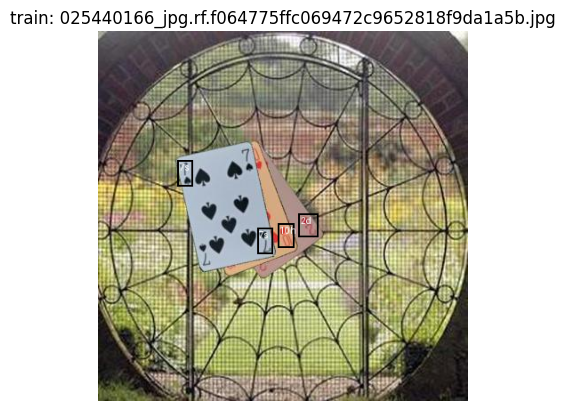

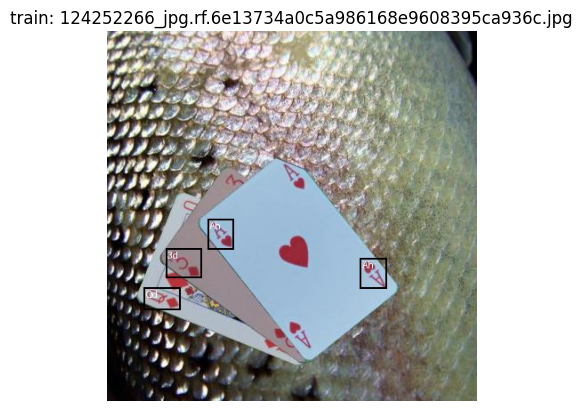

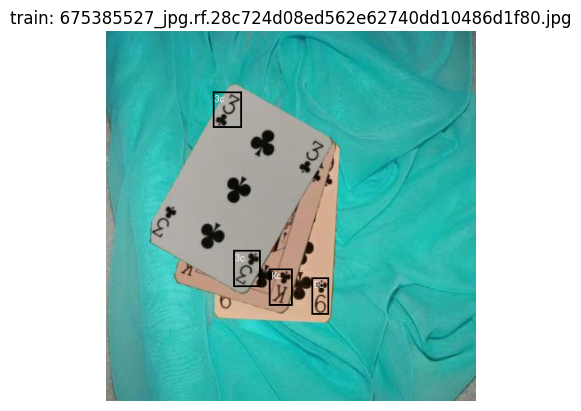

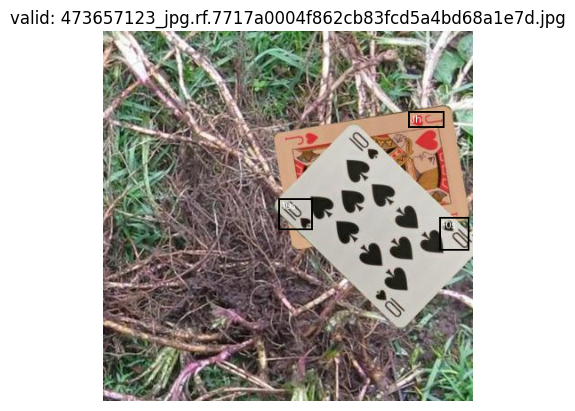

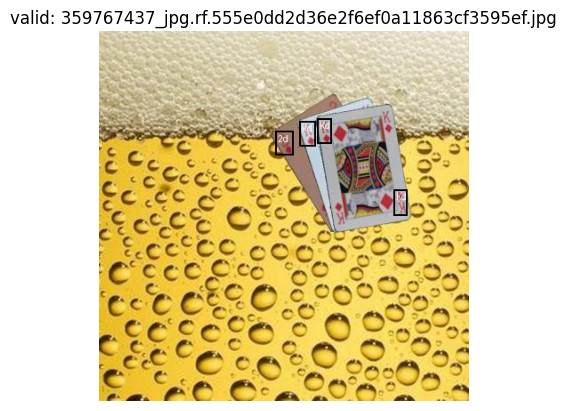

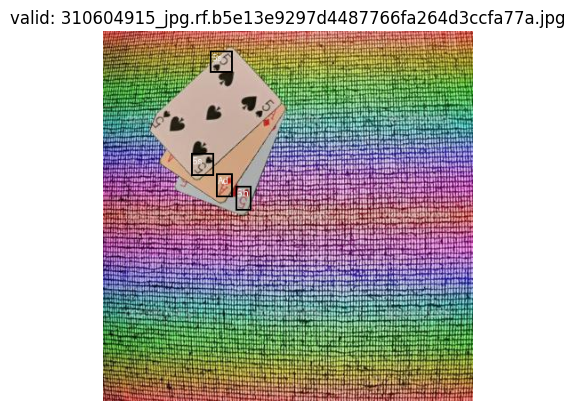

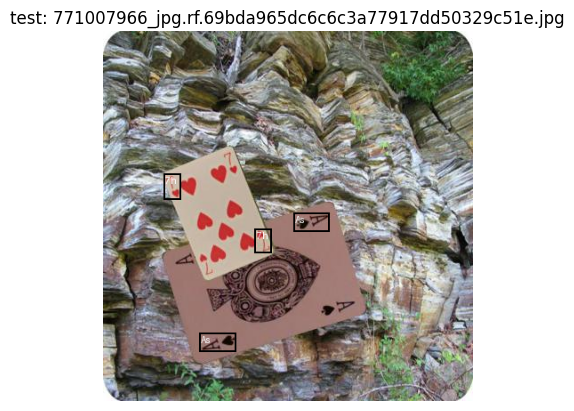

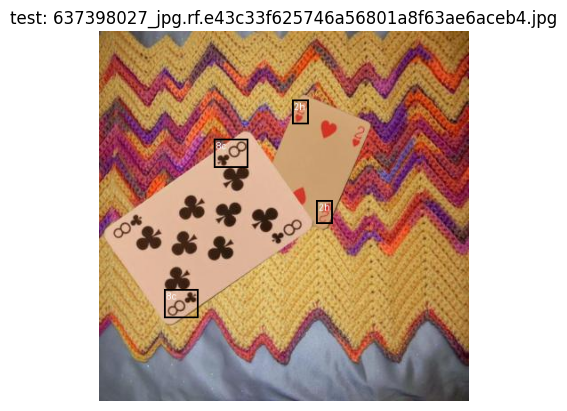

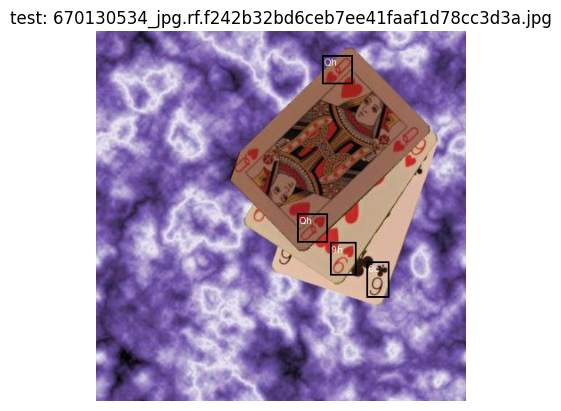

In [20]:
def draw_yolo_boxes(image_path, label_path, class_names=None, max_boxes=50):
    im = Image.open(image_path).convert("RGB")
    W, H = im.size
    draw = ImageDraw.Draw(im)
    if label_path and os.path.exists(label_path):
        items = read_label_file(label_path)[:max_boxes]
        for (cls, xc, yc, w, h) in items:
            x1, y1, x2, y2 = yolo_to_xyxy(xc, yc, w, h, W, H)
            # rectangle + text
            draw.rectangle([x1, y1, x2, y2], outline=1, width=2)
            label = str(cls) if class_names is None else f"{class_names[cls] if cls < len(class_names) else cls}"
            draw.text((x1+2, y1+2), label)
    return im

# Randomly select and display 3 samples per split with bounding boxes
random.seed(0)
for split in splits.keys():
    subset = df[(df['split']==split) & (~df['label_path'].isna())]
    sample = subset.sample(min(3, len(subset))) if len(subset) else pd.DataFrame()
    for _, row in sample.iterrows():
        im = draw_yolo_boxes(row['image_path'], row['label_path'], classes)
        plt.figure()
        plt.imshow(im)
        plt.axis('off')
        plt.title(f'{split}: {Path(row["image_path"]).name}')
        plt.show()

### 6) Images Statistics

We count the number of bounding boxes per image.

In [ ]:
print("\n" + "=" * 60)
print("BOUNDING BOXES PER IMAGE STATISTICS")
print("=" * 60)

# calculates the number of bbox per image
bbox_per_image = labels_df.groupby('image_path').size()

# Create detailed statistics
bbox_counts = bbox_per_image.value_counts().sort_index()

# Create a summary table
bbox_stats = []
for num_bbox, num_images in bbox_counts.items():
    percentage = (num_images / len(bbox_per_image) * 100)
    bbox_stats.append({
        'BBoxes per Image': num_bbox,
        'Number of Images': num_images,
        'Percentage': f"{percentage:.2f}%"
    })

bbox_stats_df = pd.DataFrame(bbox_stats)
print("\n" + bbox_stats_df.to_string(index=False))

# Istogramma
plt.figure(figsize=(10, 6))
bbox_per_image.hist(bins=30, edgecolor='black')
plt.title('Number of Bounding Boxes per Image')
plt.xlabel('Bounding boxes per image')
plt.ylabel('Number of images')
plt.xticks([1, 2, 3])
plt.xlim(0.5, 3.5)
plt.grid(axis='y', alpha=0.3)
plt.show()

# Scatter dei centri bbox normalizzati (xc, yc)
if len(labels_df) > 0:
    n = min(10000, len(labels_df))
    sample_centers = labels_df.sample(n, random_state=0)[["xc", "yc"]].dropna()
    plt.figure(figsize=(8, 8))
    plt.scatter(sample_centers["xc"], sample_centers["yc"], s=4, alpha=0.5)
    plt.title("BBox Centers Distribution (Normalized [0-1])")
    plt.xlabel("xc (normalized)")
    plt.ylabel("yc (normalized)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")

# Scatter w vs h delle bbox (YOLO normalizzato)
if len(labels_df) > 0:
    bb = labels_df[["w", "h"]].dropna()
    n = min(20000, len(bb))
    bb = bb.sample(n, random_state=0)
    plt.figure(figsize=(8, 8))
    plt.scatter(bb["w"], bb["h"], s=4, alpha=0.5)
    plt.title("BBox Dimensions (Width vs Height) [Normalized 0-1]")
    plt.xlabel("width (normalized)")
    plt.ylabel("height (normalized)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print("labels_df è vuoto: nessuna bbox da visualizzare.")

# Classi uniche per immagine
classes_per_image = labels_df.groupby('image_path')['class_id'].nunique()

# Statistiche classi uniche per immagine
unique_class_stats = []
unique_counts = classes_per_image.value_counts().sort_index()
for num_classes, num_images in unique_counts.items():
    percentage = (num_images / len(classes_per_image) * 100)
    unique_class_stats.append({
        'Unique Classes per Image': num_classes,
        'Number of Images': num_images,
        'Percentage': f"{percentage:.2f}%"
    })

unique_stats_df = pd.DataFrame(unique_class_stats)
print("\n" + "=" * 60)
print("UNIQUE CLASSES PER IMAGE STATISTICS")
print("=" * 60)
print("\n" + unique_stats_df.to_string(index=False))

print("\n" + "-" * 60)
print(f"Mean unique classes per image: {classes_per_image.mean():.2f}")
print(f"Median unique classes per image: {classes_per_image.median():.0f}")
print("=" * 60)

plt.figure(figsize=(10, 6))
classes_per_image.hist(bins=30, edgecolor='black')
plt.title('Number of Unique Classes per Image')
plt.xlabel('Unique classes per image')
plt.ylabel('Number of images')
plt.grid(axis='y', alpha=0.3)
plt.show()


BOUNDING BOXES PER IMAGE STATISTICS
RangeIndex(start=0, stop=0, step=1)


KeyError: 'image_path'

### 7) Check for labels anomalies
We check for anomalies in the labels such as:
- bounding boxes with normalized coordinates outside [0,1]
- bounding boxes with zero area (width or height equal to zero)
- images without any bounding boxes

In [34]:
# bounding boxes with normalized coordinates outside [0,1]
out_of_bounds = labels_df.query('xc<0 or xc>1 or yc<0 or yc>1 or w<0 or w>1 or h<0 or h>1').shape[0]
print("Bbox with normalized coordinates outside [0,1]:", out_of_bounds)

# bounding boxes with zero area
too_small = labels_df.query('w*h < 1e-5').shape[0]
too_big = labels_df.query('w>0.9 or h>0.9').shape[0]
print("Bbox with zero area:", too_small)
print("Bbox with very large dimensions (w>0.9 or h>0.9):", too_big)

# images without any bounding boxes
missing_pct = df['label_path'].isna().mean()*100
print(f"Images without any bbox: {missing_pct:.2f}%")

Bbox with normalized coordinates outside [0,1]: 0
Bbox with zero area: 0
Bbox with very large dimensions (w>0.9 or h>0.9): 0
Images without any bbox: 0.00%
